## Comparison of MUF Uncertainty Formats
#### Path 1. No error on file for comparison
1. Import a list of files for the Monte Carlo files
2. Calculate a mean (or median) and a standard deviation file using frequency_model_collapse
3. Change the uncertainty column names and join the table 
4. Create a standard error table with the file that you want to compare

#### Path 2. Comparison of Monte Carlo and sensitivity analysis
1. Import a list of files for the Monte Carlo files
2. Calculate a mean (or median) and a standard deviation file using frequency_model_collapse
3. Change the uncertainty column names and join the table 
4. Import a list of files for the sensitivity analysis
5. Import the nominal value file
5. Find the difference of the nominal file and sensitivity analysis
6. 


In [1]:
import os
import wx
from pyMeasure import *

Importing Code.Utils.Names
Importing Code.DataHandlers.NISTModels
The module smithplot was not found,please put it on the python path
Importing Code.DataHandlers.GeneralModels
Importing Code.DataHandlers.TouchstoneModels
The module smithplot was not found,please put it on the python path
Importing Code.DataHandlers.XMLModels
Importing Code.DataHandlers.RadiCALModels
Importing Code.DataHandlers.ZipModels
Importing Code.DataHandlers.Translations
Importing Code.DataHandlers.StatistiCALModels
Importing Code.DataHandlers.MUFModels
Importing Code.Analysis.SParameter
Importing Code.Analysis.Uncertainty
Importing Code.InstrumentControl.Instruments
Importing Code.InstrumentControl.Experiments


In [2]:
MUF_RESULTS_DIRECTORY=r'C:\Share\MUF_FILES\DUTs'
MONTECARLO_DIRECTORY=os.path.join(MUF_RESULTS_DIRECTORY,r"Open_SOLT_Support\MonteCarlo")
MONTECARLO_FILES=os.listdir(MONTECARLO_DIRECTORY)
nominal_file=SNP(os.path.join(MUF_RESULTS_DIRECTORY,r"Open_SOLT_Support\Open_SOLT_0.s2p"))

In [3]:
def get_directory():
    """Creates a directory dialog and returns the selected directory"""
    app = wx.App(None)
    dialog = wx.DirDialog(None, 'Select a MonteCarlo Directory')
    if dialog.ShowModal() == wx.ID_OK:
        path = dialog.GetPath()
    else:
        path = None
    dialog.Destroy()
    return path
def get_path(wildcard='*.*'):
    """Creates a file dialog and returns the selected file"""
    app = wx.App(None)
    style = wx.FD_OPEN | wx.FD_FILE_MUST_EXIST
    dialog = wx.FileDialog(None, 'Open',wildcard=wildcard, style=style)
    if dialog.ShowModal() == wx.ID_OK:
        path = dialog.GetPath()
    else:
        path = None
    dialog.Destroy()
    return path

In [51]:
get_directory()

u'C:\\Share\\MUF_FILES\\DUTs\\Open_SOLT_Support\\MonteCarlo'

In [4]:
initial_file=S2PV1(os.path.join(MONTECARLO_DIRECTORY,MONTECARLO_FILES[0]))
combined_table=Snp_to_AsciiDataTable(initial_file)
for file_name in MONTECARLO_FILES[1:]:
    snp_file=S2PV1(os.path.join(MONTECARLO_DIRECTORY,file_name))
    table=Snp_to_AsciiDataTable(snp_file)
    combined_table+table
mean_table=frequency_model_collapse_multiple_measurements(combined_table)
standard_deviation=frequency_model_collapse_multiple_measurements(combined_table,
                                                                  method='std')
new_column_names=['Frequency']+['u'+name for name in standard_deviation.column_names[1:]]
standard_deviation.column_names=new_column_names
reference_curve=ascii_data_table_join("Frequency",mean_table,standard_deviation)

In [5]:
initial_file_snp=SNP(os.path.join(MONTECARLO_DIRECTORY,MONTECARLO_FILES[0]))
combined_table_snp=Snp_to_AsciiDataTable(initial_file)
for file_name in MONTECARLO_FILES[1:]:
    snp_file=SNP(os.path.join(MONTECARLO_DIRECTORY,file_name))
    table=Snp_to_AsciiDataTable(snp_file)
    #print(str(table).splitlines()[0:2])
    # This is not acting how I would expect
    combined_table_snp+table
    #print(str(str(combined_table_snp).splitlines()[0:2])+" length {0}".format(len(combined_table_snp.data)))
mean_table_snp=frequency_model_collapse_multiple_measurements(combined_table_snp)
standard_deviation_snp=frequency_model_collapse_multiple_measurements(combined_table_snp,
                                                                  method='std')
new_column_names=['Frequency']+['u'+name for name in standard_deviation_snp.column_names[1:]]
standard_deviation_snp.column_names=new_column_names
reference_curve_snp=ascii_data_table_join("Frequency",mean_table_snp,standard_deviation_snp)

In [6]:
initial_file_snp.column_names==initial_file.column_names

True

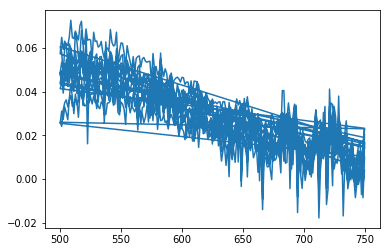

In [8]:
plt.plot(combined_table_snp["Frequency"],combined_table_snp["reS11"])
#plt.plot(combined_table["Frequency"],combined_table["reS11"])
plt.show()

In [11]:
standard_error=standard_error_data_table(reference_curve_snp,nominal_file,
                                         value_column_names=mean_table.column_names[1:],
                                        table_1_uncertainty_column_names=new_column_names[1:],
                                        expansion_factor=1)

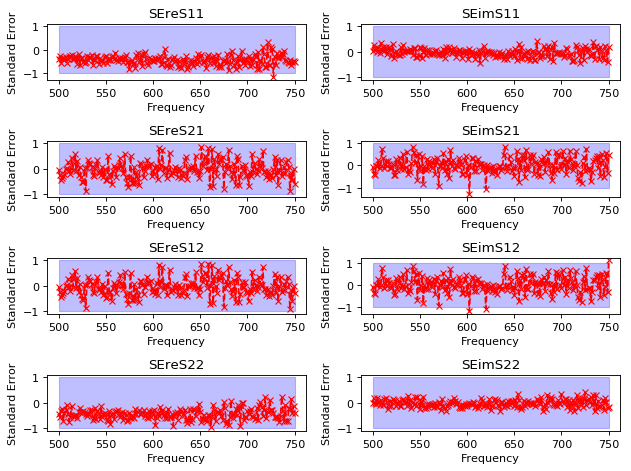

In [12]:
standard_error.show();

In [9]:
def Snp_to_AsciiDataTable(snp_model):
    """Converts snp files to AsciiDataTable"""
    options=snp_model.options
    options['data']=snp_model.data
    options['column_names']=snp_model.column_names
    options['column_types']=['float' for i in snp_model.column_names]
    options["extension"]="txt"
    new_table=AsciiDataTable(None,**options)
    return new_table

In [19]:
new_table=Snp_to_AsciiDataTable(initial_file)

In [4]:
def create_monte_carlo_reference_curve(monte_carlo_directory,**options):
    """Creates a standard curve from a montecarlo directory (from MUF). The standard curve
    has a mean or median and a standard deviation for the uncertainty"""
    defaults={"method":"mean","format":"RI","filter":"s\d+p"}
    reference_options={}
    for key,value in defaults.iteritems():
        reference_options[key]=value
    for key,value in options.iteritems():
        reference_options[key]=value
    file_names=os.listdir(monte_carlo_directory)
    filtered_file_names=[]
    for file_name in file_names[:]:
        if re.search(reference_options["filter"],file_name,re.IGNORECASE):
            filtered_file_names.append(file_name)
    file_names=filtered_file_names
    print file_names
    initial_file=SNP(os.path.join(monte_carlo_directory,file_names[0]))
    initial_file.change_data_format(reference_options["format"])
    combined_table=Snp_to_AsciiDataTable(initial_file)
    
    for file_name in file_names[1:]:
        snp_file=SNP(os.path.join(monte_carlo_directory,file_name))
        snp_file.change_data_format(reference_options["format"])
        table=Snp_to_AsciiDataTable(snp_file)
        combined_table+table
    mean_table=frequency_model_collapse_multiple_measurements(combined_table,method=reference_options["method"])
    standard_deviation=frequency_model_collapse_multiple_measurements(combined_table,
                                                                      method='std')
    new_column_names=['Frequency']+['u'+name for name in standard_deviation.column_names[1:]]
    standard_deviation.column_names=new_column_names
    reference_curve=ascii_data_table_join("Frequency",mean_table,standard_deviation)
    reference_curve.options["value_column_names"]=mean_table.column_names[1:]
    reference_curve.options["uncertainty_column_names"]=new_column_names[1:]
    return reference_curve

def plot_reference_curve(reference_curve,**options):
    """Plots a frequency based reference curve by using the options 
    value_column_names and uncertainty_column_names"""
    

[u'Solution_0.s4p', u'Solution_1.s4p', u'Solution_10.s4p', u'Solution_2.s4p', u'Solution_3.s4p', u'Solution_4.s4p', u'Solution_5.s4p', u'Solution_6.s4p', u'Solution_7.s4p', u'Solution_8.s4p', u'Solution_9.s4p']


<IPython.core.display.Javascript object>


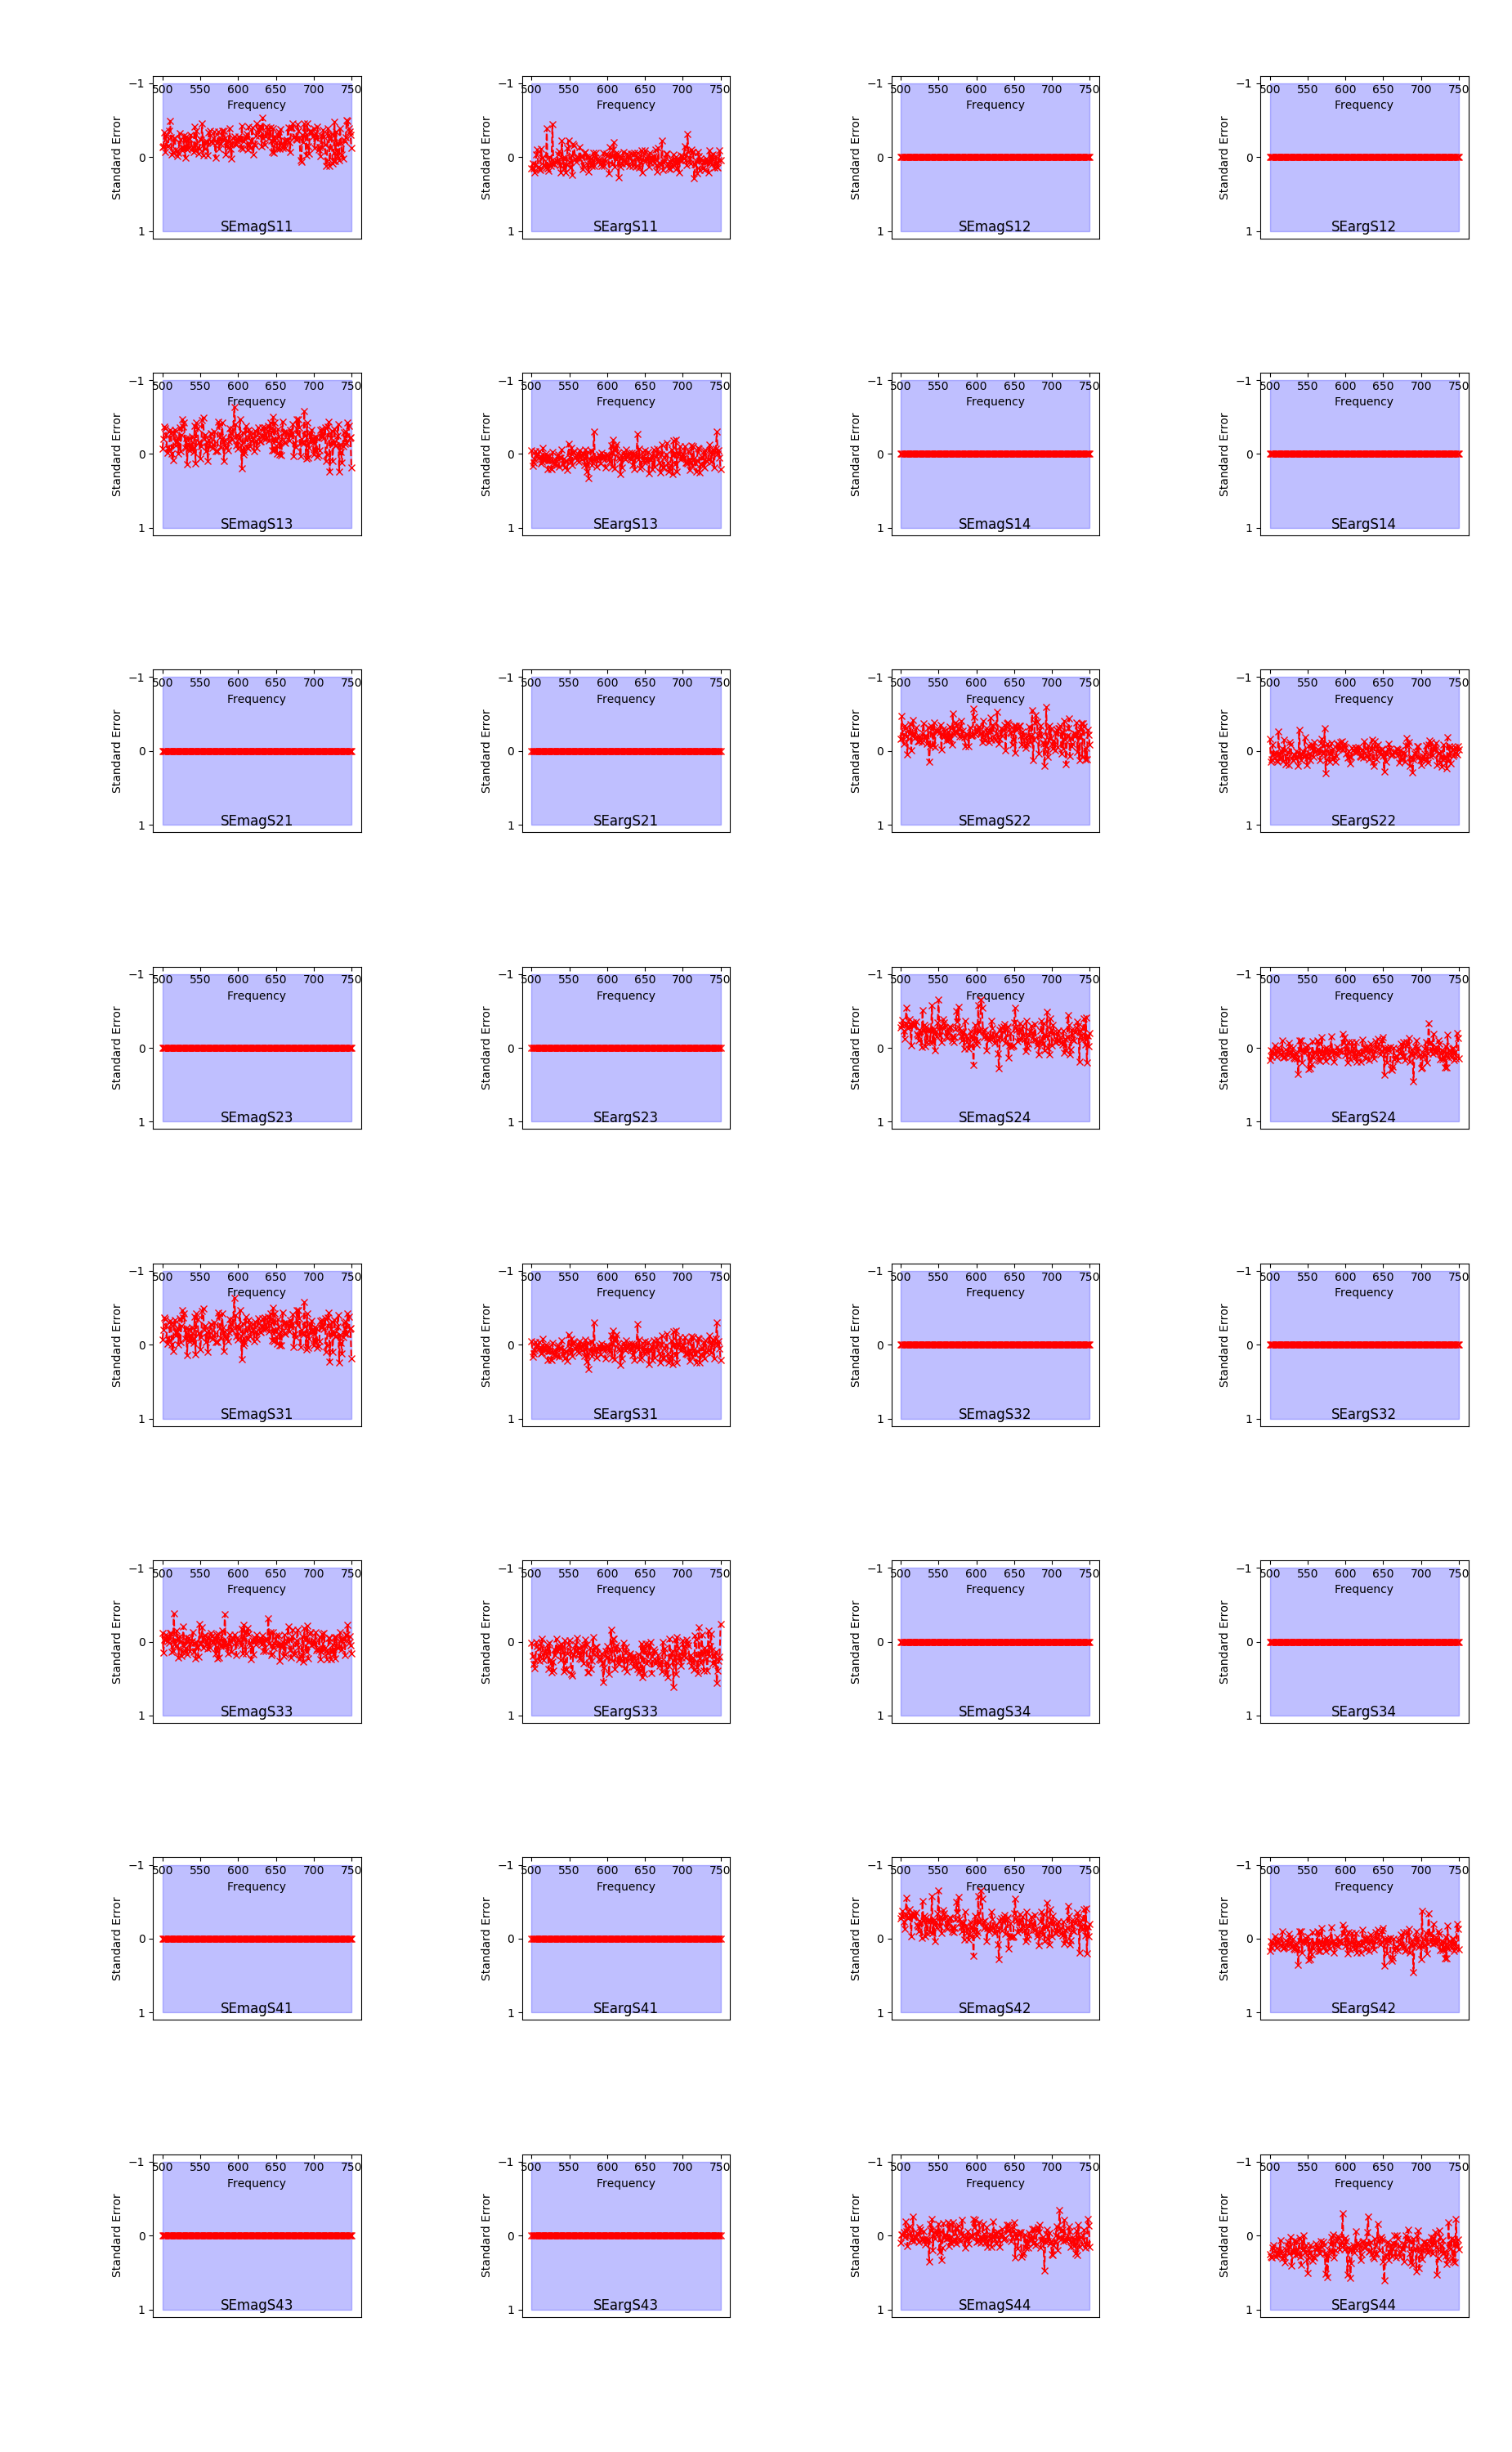

In [19]:
%matplotlib notebook
data_format="MA"
montecarlo_directoy=get_directory()
reference_curve=create_monte_carlo_reference_curve(montecarlo_directoy,format=data_format)
comparison_path=get_path("*.s*p")
comparison_file=SNP(comparison_path)
comparison_file.change_data_format(data_format)
comparison_file=Snp_to_AsciiDataTable(comparison_file)
standard_error=standard_error_data_table(reference_curve,comparison_file,
                                         value_column_names=reference_curve.options["value_column_names"],
                                        table_1_uncertainty_column_names=reference_curve.options["uncertainty_column_names"],
                                        expansion_factor=2)
fig=standard_error.show(plots_per_column=4);

In [20]:
fig.set_size_inches(18.5, 30)
fig.savefig("test.png")


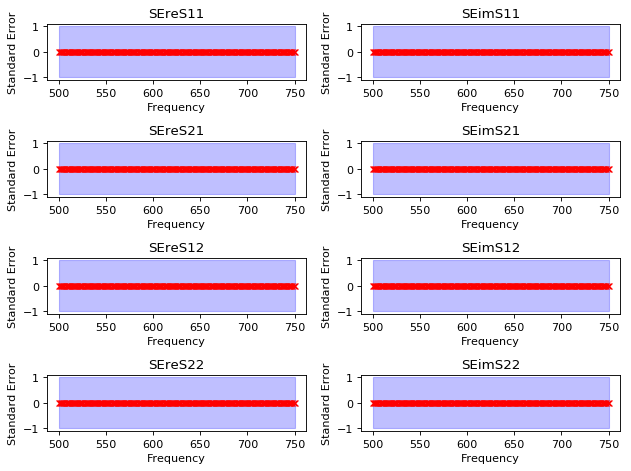

In [13]:
montecarlo_directoy=get_directory()
reference_curve=create_monte_carlo_reference_curve(montecarlo_directoy,format="RI")
comparison_path=get_path("*.s2p")
comparison_file=Snp_to_AsciiDataTable(SNP(comparison_path))
standard_error=standard_error_data_table(reference_curve,comparison_file,
                                         value_column_names=mean_table.column_names[1:],
                                        table_1_uncertainty_column_names=new_column_names[1:],
                                        expansion_factor=2)
standard_error.show();

In [14]:
s2p=S2PV1(os.path.join(MONTECARLO_DIRECTORY,MONTECARLO_FILES[0]))
snp=SNP(os.path.join(MONTECARLO_DIRECTORY,MONTECARLO_FILES[0]))

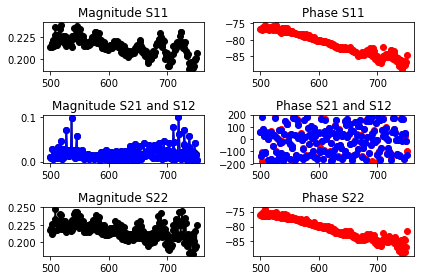

In [16]:
s2p.show();

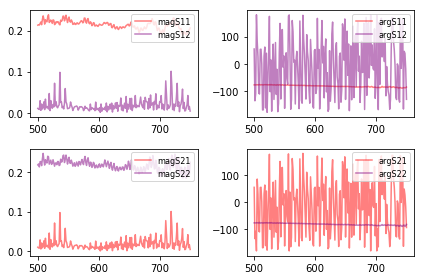

In [18]:
snp.show();

In [22]:
reference_curve.data[0:1]

[[500.0,
  -0.800119316516692,
  -0.320355122257068,
  0.275148380100635,
  -0.417246015307572,
  0.279881516290309,
  -0.420804533000747,
  -0.796711380119375,
  -0.315840107867928,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0]]

In [27]:
reference_curve_s2p.data[0:1]

[[500.0,
  0.04464714932238384,
  -0.2074568452113814,
  0.006025742828435452,
  0.008466680957820105,
  0.006113603770844101,
  0.008579417038542104,
  0.04739649421942263,
  -0.21133539299220108,
  0.010430311559001176,
  0.008263658067640525,
  0.00012110352532165926,
  9.597965447921214e-05,
  0.00012276170755797842,
  9.730595129931846e-05,
  0.011512660760406596,
  0.007331103242114687]]

In [31]:
standard_deviation.data[0:1]

[[0.0,
  0.010430311559001176,
  0.008263658067640525,
  0.00012110352532165926,
  9.597965447921214e-05,
  0.00012276170755797842,
  9.730595129931846e-05,
  0.011512660760406596,
  0.007331103242114687]]

In [32]:
standard_deviation_snp.data[0:1]

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

In [37]:
combined_table["Frequency"]==combined_table_snp["Frequency"]

False

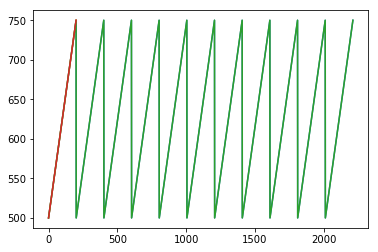

In [39]:
import matplotlib.pyplot as plt
plt.plot(combined_table["Frequency"])
plt.plot(combined_table_snp["Frequency"])
plt.show()